<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()
None

In [5]:
data = data.transpose((0, 3, 1, 2)).astype('float32')
data.dtype, data.shape

(dtype('float32'), (13143, 3, 64, 64))


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [6]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, test_size=0.2, shuffle=False)

batch_size = 32

data_train = torch.utils.data.DataLoader(train_photos, batch_size=batch_size)
data_val = torch.utils.data.DataLoader(val_photos, batch_size=batch_size)

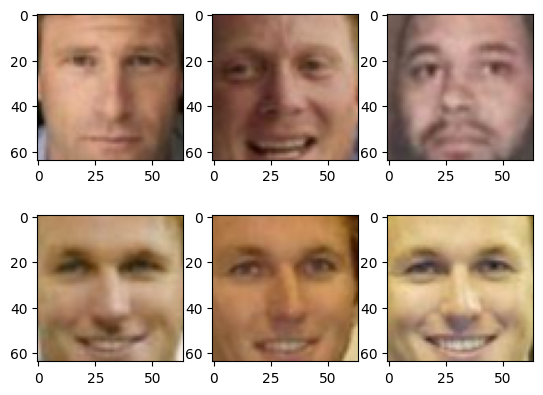

In [7]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(data[i].transpose((1, 2, 0)))
plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [8]:
dim_code = 64

In [9]:
data[0].shape

(3, 64, 64)

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, kernel_size=7),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=7),
            nn.BatchNorm2d(32),
        )
        self.fc = nn.Linear(32 * 46 * 46, dim_code)
        self.fc1 = nn.Linear(dim_code, 32 * 46 * 46)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 128, kernel_size=7),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size=7),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=7),
        )
              
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        latent = self.fc(x)
        res = self.fc1(latent).view((-1, 32, 46, 46))
        res = self.decoder(res)

        return res, latent

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
criterion = nn.MSELoss()

model = Autoencoder().to(device)

optimizer = torch.optim.Adam(model.parameters())

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

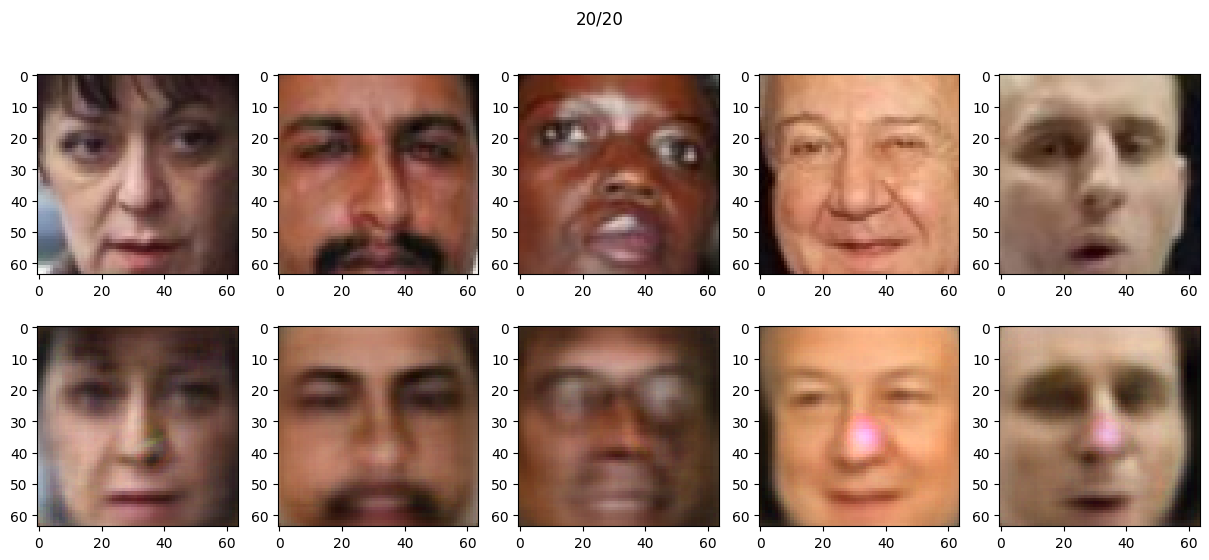

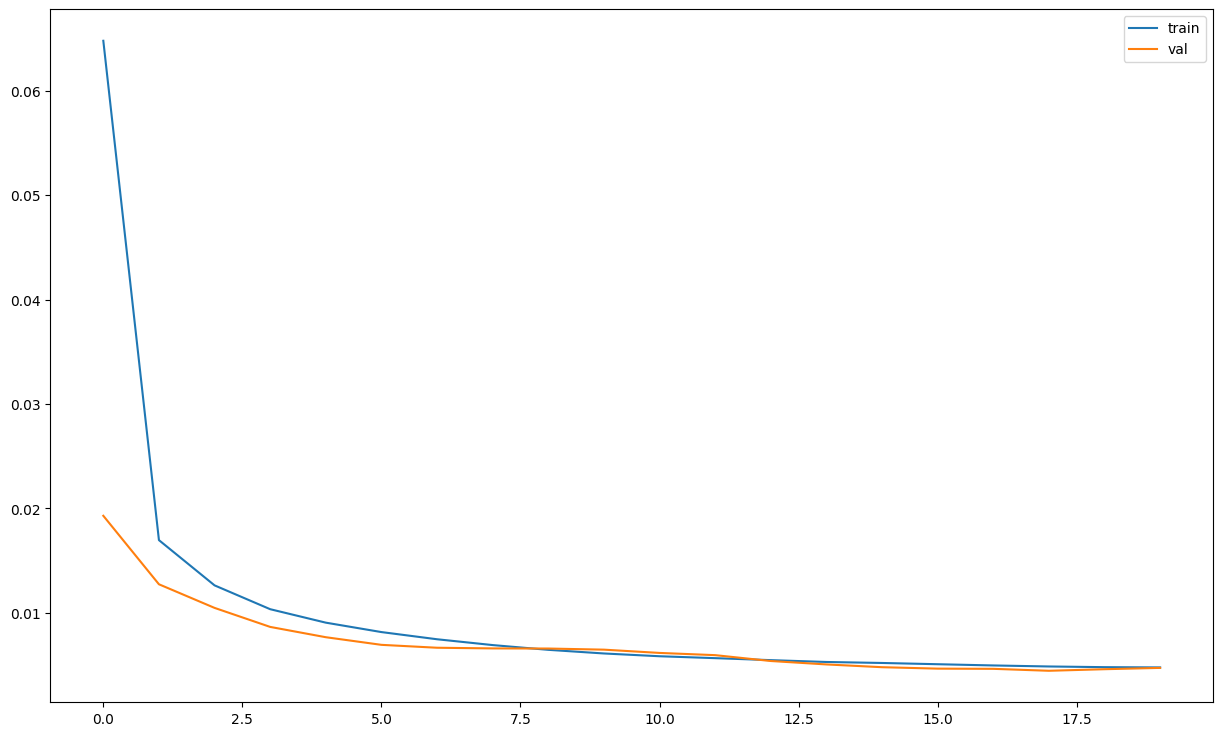

In [13]:
n_epochs = 20

train_losses, val_losses = [], []
latents = torch.Tensor()
ground_truth = torch.Tensor()
preds = torch.Tensor()

for epoch in range(n_epochs):
    latents = torch.Tensor()
    ground_truth = torch.Tensor()
    preds = torch.Tensor()
    model.train()
    train_epoch_losses = []
    for X_batch in data_train:
        optimizer.zero_grad()
        res, latent = model(X_batch.to(device))
        loss = criterion(res, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_epoch_losses.append(loss.item())

    train_losses.append(np.mean(train_epoch_losses))
    
    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for X_batch in data_val:
            res, latent = model(X_batch.to(device))
            loss = criterion(res, X_batch.to(device))
            val_epoch_losses.append(loss.item())
            if len(latents) == 0:
                ground_truth = X_batch.cpu()
                latents = latent.cpu()
                preds = res.cpu()
    val_losses.append(np.mean(val_epoch_losses))
    
    clear_output(wait=True)
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'{epoch+1}/{n_epochs}')
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_batch[i].cpu().numpy().transpose((1, 2, 0)))
        
        plt.subplot(2, 5, i+6)
        plt.imshow(res[i].cpu().numpy().transpose((1, 2, 0)))
    plt.show()

plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

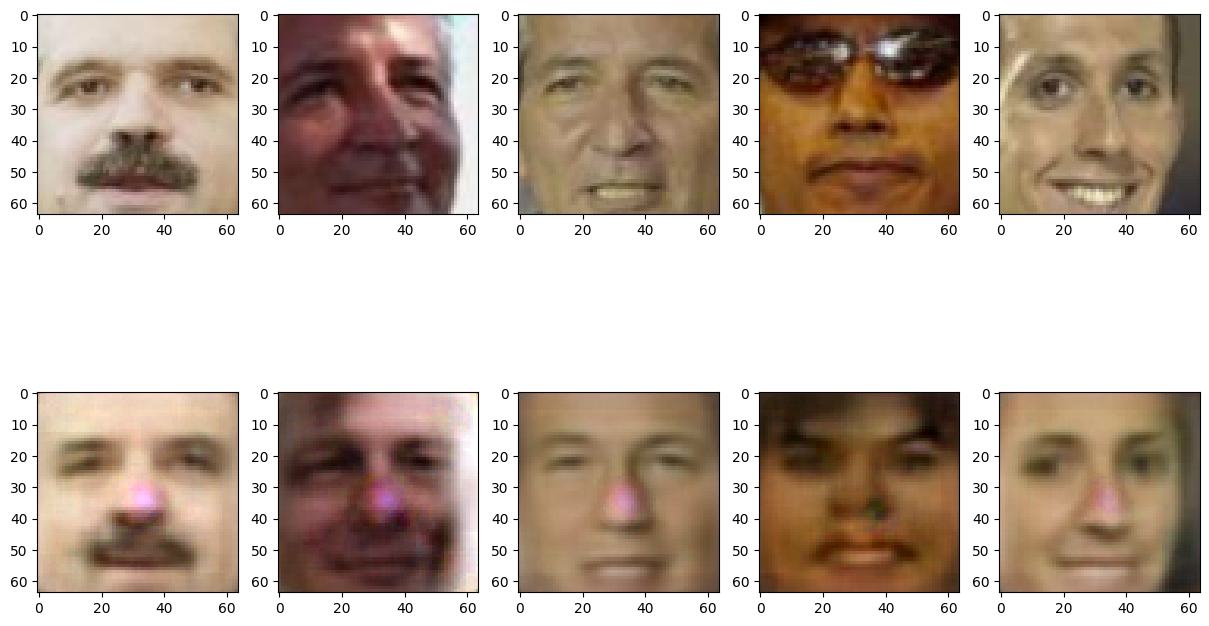

In [14]:
plt.figure(figsize=(15, 9))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(ground_truth[i].cpu().numpy().transpose((1, 2, 0)))
    
    plt.subplot(2, 5, i+6)
    plt.imshow(preds[i].cpu().numpy().transpose((1, 2, 0)))
plt.show()

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

tensor(-4.1327, device='cuda:0') tensor(4.9965, device='cuda:0')


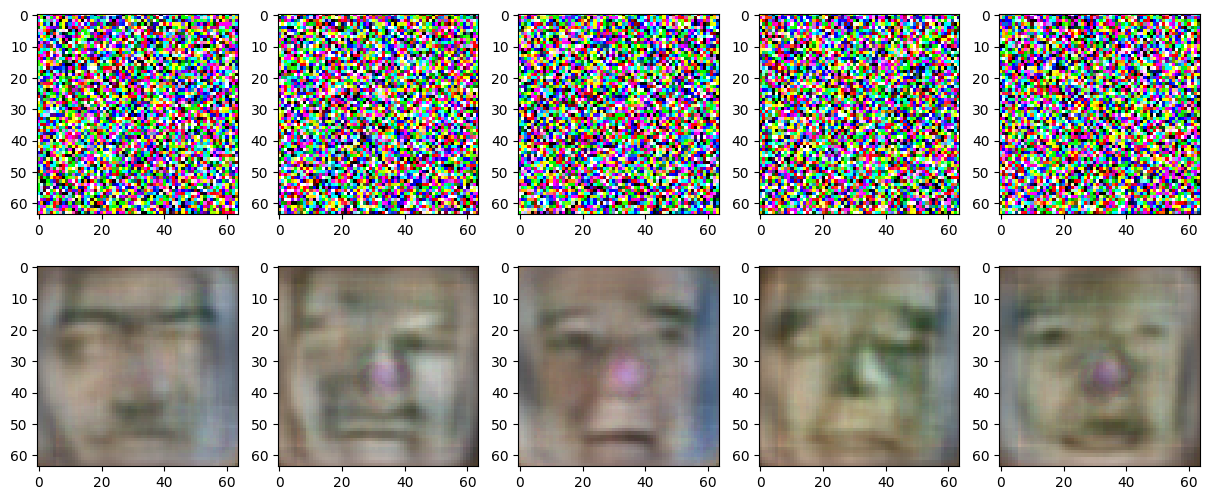

In [15]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.Tensor(np.random.randn(25, 3, 64, 64) + 0.5).to(device)
print(z.min(), z.max())
with torch.no_grad():
    model.eval()
    output, latent = model(z)
    plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(z[i].cpu().numpy().transpose((1, 2, 0)))
    
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].cpu().numpy().transpose((1, 2, 0)))
plt.show()

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

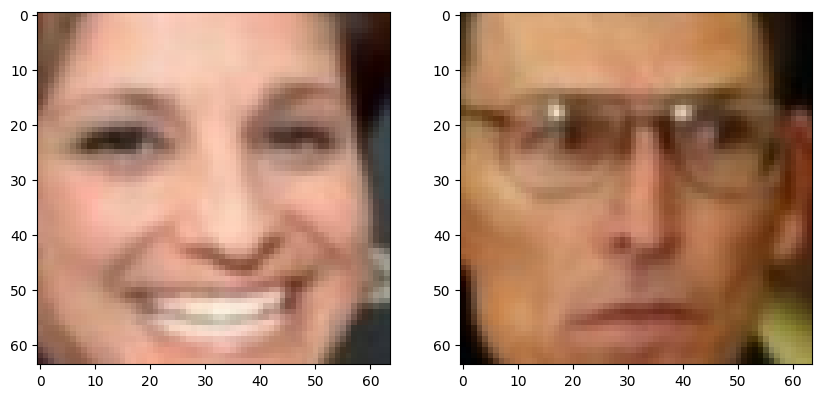

In [16]:
smiling_id = attrs.sort_values(by='Smiling', ascending=False).iloc[:50].index
sad_id = attrs.sort_values(by='Smiling', ascending=False).iloc[-50:].index
smiling_data = torch.FloatTensor(data[smiling_id])
sad_data = torch.FloatTensor(data[sad_id])
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(smiling_data[0].numpy().transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(sad_data[0].numpy().transpose((1, 2, 0)))
plt.show()

In [17]:
def mean_latent(x):
    with torch.no_grad():
        model.eval()
        res, latent = model(x.to(device))
        return latent, torch.mean(latent, 0)

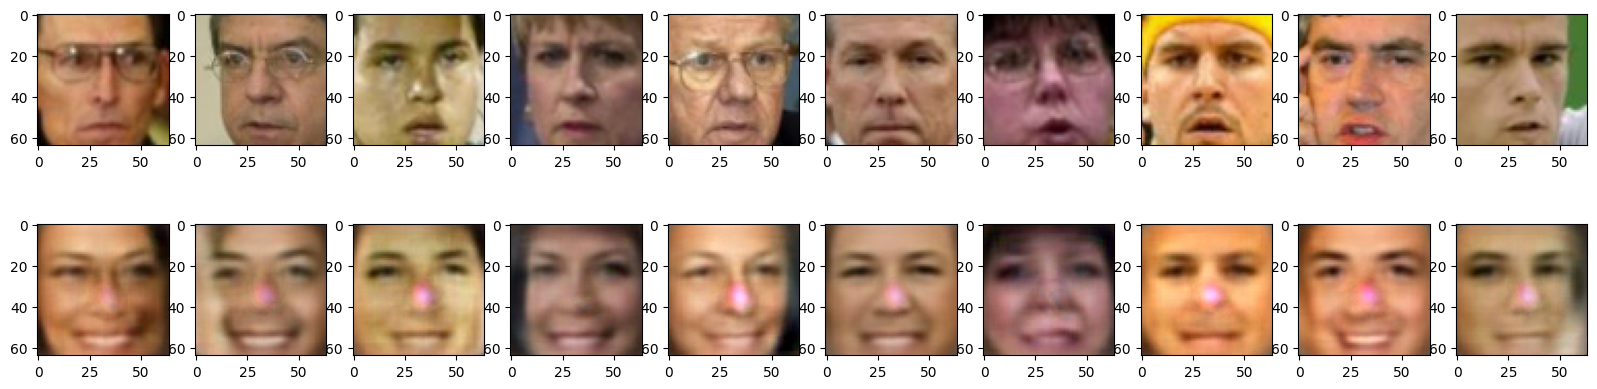

In [18]:
smiling_latent, smiling_mean = mean_latent(smiling_data)
sad_latent, sad_mean = mean_latent(sad_data)

diff = smiling_mean - sad_mean
changed_latent = sad_latent + diff

with torch.no_grad():
    output = model.decoder(model.fc1(changed_latent).view(-1, 32, 46, 46))
plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(sad_data[i].numpy().transpose((1, 2, 0)))
    
    plt.subplot(2, 10, i+11)
    plt.imshow(output[i].cpu().numpy().transpose((1, 2, 0)))
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)